# Effect of municipalities on education level

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
#from dataproject import dataprojectClass

%pip install git+https://github.com/elben10/pydst
%pip install pandas-datareader
import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  Cloning https://github.com/elben10/pydst to /private/var/folders/6g/ztqdjshx67n8pkkmdc8z2c3w0000gp/T/pip-req-build-7wh7so_r
  Running command git clone --quiet https://github.com/elben10/pydst /private/var/folders/6g/ztqdjshx67n8pkkmdc8z2c3w0000gp/T/pip-req-build-7wh7so_r
  Resolved https://github.com/elben10/pydst to commit bb347560a1b3c17684fda072c829658da38f5a72
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Read and clean data

In this part, we define functions, that we later use.

In [24]:
#Defining a function to extract data from DST
def get_data(table, variables_list):
    Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'
    
    plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
    plt.rcParams.update({'font.size': 14})
    tables = Dst.get_tables(subjects=['2'])
    #
    Dst = pydst.Dst(lang='en') 
    Dst.get_subjects()
    tables = Dst.get_tables(subjects=['4'])
    tables[tables.id == table]
    indk_vars = Dst.get_variables(table_id=table)
    #
    variables = variables_list
    df = Dst.get_data(table_id = table, variables=variables)
    return df

#Defining a function to convert a string to float by first removing part of string
def string_to_float(variabel, strip_string):
    string = variabel.map(lambda x: x.rstrip(strip_string))
    float = string.astype('float64')
    return float
    
    
#Defining a function to drop certain observations
def drop_obs(df, column, value, equality = "not_equal"):
    if equality == "not_equal":
        not_dropped = df.drop(df[df[column] != value].index, inplace = True)
    return not_dropped

#Defining a function to drop variables/columns
def drop_variables(df, columns):
    not_dropped = df.drop(columns=columns, inplace = True)
    return not_dropped
df

,KOMK,ALDER,TID,KØN,BYST,INDHOLD,ALDERSGRUPPE,tot_koen,tot_aldersgruppe
239,Gribskov,25.0,2022,Men,250-499 inhabitants,4,25-39,270,4970
240,Gribskov,25.0,2022,Women,250-499 inhabitants,7,25-39,270,4970
241,Gribskov,26.0,2022,Men,250-499 inhabitants,8,25-39,252,4970
242,Gribskov,26.0,2022,Women,250-499 inhabitants,1,25-39,252,4970
243,Gribskov,27.0,2022,Men,250-499 inhabitants,6,25-39,276,4970
...,...,...,...,...,...,...,...,...,...
127325,Nordfyns,32.0,2022,Women,250-499 inhabitants,13,25-39,281,4297
127326,Nordfyns,33.0,2022,Men,250-499 inhabitants,10,25-39,269,4297
127327,Nordfyns,33.0,2022,Women,250-499 inhabitants,9,25-39,269,4297
127328,Nordfyns,34.0,2022,Men,250-499 inhabitants,10,25-39,289,4297


In this part, we clean the first dataset. The dataset contains population data from DST from 2010 and 2022 from every municipality in Denmark. We generate separate datasets from each year through a loop and join them afterwards using concatenation - This is done by assigning each dataset its corresponding year as the key in a dictionay.
. We only keep observations belong to the relevant age group (25 - 39 years). We sum over all age groups using the groupby function. In the end, we merge with a dataset that links each municipality to a region.

In [25]:
#Population Dataset
import itertools
 
year = [2010, 2022]
year_string = ['2010', '2022']

#creating empty dataframe dictionary
pop_df = {}
 
# iterates over 3 lists and executes
# 2 times as len(value)= 2 which is the
# minimum among all the three
for (year, year_string) in zip(year, year_string):

    variables = {'KOMK':['*'], 'ALDER':['*'], 'TID':[year_string], 'KØN':['*'],'BYST':["*"]}
    df1 = get_data("BY2", variables)
    df = df1
    #cleaning data, converting string to float and only keeping people in the desired agegroup (25 - 39) 
    df['ALDER'] = string_to_float(df["ALDER"], " years")
    df.loc[df['ALDER'].between(25,39), 'ALDERSGRUPPE'] = '25-39'
    ##Dropping observations outside time frame and outside age group
    drop_obs(df, "TID", year, equality = "not_equal")
    drop_obs(df, "ALDERSGRUPPE", '25-39' , equality = "not_equal")

    ####HVILKE VARIABLE SKAL SUMMERES OVER??

    df['total_pop'] = df.groupby(['KOMK'])['INDHOLD'].transform('sum')
    ##Dropping unnecessary variables
    drop_variables(df, ['ALDER', 'BYST', "INDHOLD", "KØN", "ALDERSGRUPPE"])
    df = df.drop_duplicates(subset=("KOMK"))
    #creating a dataframe for each year
    pop_df[year] = df

#Directing to placement of each dataset in dictionary
pop_df2010 = pop_df[2010]
pop_df2022 = pop_df[2022]

##Concatenate datasets
pop_df_concatenate = pd.concat([pop_df2010,pop_df2022])

In [26]:
# Merging population dataset with a dataset containing data linking municipalities to regions

excel_file = "kommuneliste.xlsx"
reg_mun = pd.read_excel(excel_file)

##changing name of København to Copenhagen so that the data sets can merge properly
reg_mun = reg_mun.replace("København", "Copenhagen")

pop_df_concatenate = pd.merge(reg_mun, pop_df_concatenate, how = 'inner', on = ['KOMK'])
pop_df_concatenate['total_pop_region'] = pop_df_concatenate.groupby(["TID","REGION"])['total_pop'].transform('sum')

In this part, we clean the second dataset. This dataset contains education data from DST from 2010 and 2022 from every municipality in Denmark. Again, we generate separate datasets from each year through a loop and join them afterwards using concatenation and only keeping observations within the relevant age group. We only keep observations belong to the relevant age group (25 - 39 years). We sum over all age groups using the gruoby function.

We group five types of higher education as "higher education". Apart from that, we keep observations with primary education or VET as the highest education completed. 

In [27]:
#ANDET DATASÆT
year = [2010, 2022]
year_string = ['2010', '2022']

edu_df = {}
 
# iterates over 3 lists and executes
# 2 times as len(value)= 2 which is the
# minimum among all the three
for (year, year_string) in zip(year, year_string):

    variables = {'BOPOMR':['*'], 'ALDER':['*'], 'HFUDD':['*'], 'TID':[year_string]}
    df_hf = get_data("HFUDD11", variables)
    df_hf.rename(columns={'BOPOMR': 'KOMK', 'ALDER': 'ALDERSGRUPPE'}, inplace=True)
    drop_obs(df_hf, "TID", year , equality = "not_equal")

    ##loop over
    age_group = ["25-29", "30-34", "35-39"]
    for x in age_group:
        df_hf.loc[df_hf['ALDERSGRUPPE'] == x + " years", 'TJEK'] = 1

    drop_obs(df_hf, "TJEK", 1 , equality = "not_equal")


    df_hf['total_in_education'] = df_hf.groupby(['KOMK', "HFUDD"])['INDHOLD'].transform('sum')

    drop_variables(df_hf, ["ALDERSGRUPPE", "TJEK",  "HERKOMST", "KØN", "ALDERSGRUPPE", "INDHOLD"])

    ## Keeping only relevant education types
    education_list = ["H10 Primary education", "H30 Vocational Education and Training (VET)", "H40 Short cycle higher education","H50 Vocational bachelors educations", "H60 Bachelors programs","H70 Masters programs","H80 PhD programs"]
    new_education_list = ["Primary education", "VET", "Higher education", "Higher education", "Higher education", "Higher education", "Higher education"]
    for i in range(7):
        df_hf.loc[df_hf['HFUDD'] == education_list[i], 'EDUCATION'] = new_education_list[i]
    df_hf = df_hf.dropna(subset=["EDUCATION"])

    df_hf = df_hf.drop_duplicates(subset=("KOMK", "HFUDD"))
    df_hf['total_in_education'] = df_hf.groupby(["KOMK", 'EDUCATION'])['total_in_education'].transform('sum')
    #drop duplicates komk og uddannelse
    df_hf = df_hf.drop_duplicates(subset=("KOMK", "EDUCATION"))
    #drop variable
   
    drop_variables(df_hf, ["HFUDD"])

    edu_df[year] = df_hf

edu_df2010 = edu_df[2010]
edu_df2022 = edu_df[2022]

##Concatenate datasets
edu_df_concatenate = pd.concat([edu_df2010, edu_df2022])

We merge the population dataset and education dataset on "Municipalities" and "Time". We use an inner join, though it does not matter since data for all municipalities exists for both years in both datasets. However, there exist some very small municipalities like Christiansø with a population of only 10 aged 25-39 years in 2022 and therefore we use an inner join to ensure that we have data from all municipalities. Finally we drop all duplicates, so that we only have the necessary data in our dataset. We group by regions and calculate the ratio of people with a certain type of education as their highest completed education in every region.

In [28]:
##merge
df_merge = pd.merge(pop_df_concatenate, edu_df_concatenate, how = 'inner', on = ['KOMK', "TID"]);

#df_merge["ratio_in_education_by_municipality"]=df_merge["total_in_education"]/df_merge["total_pop"]*100



##summer over regioner og uddannelse
df_merge['total_in_education_region'] = df_merge.groupby(["TID", "REGION", 'EDUCATION'])['total_in_education'].transform('sum')
##final_df['total_pop_region'] = final_df.groupby(["TID", "REGION"])['total_pop'].transform('sum')/3

df_merge = df_merge.drop_duplicates(subset=("TID","REGION", "EDUCATION"))

#drop variable
drop_variables(df_merge, ['KOMK','total_pop','total_in_education'])

# generating ratio in each region
df_merge["ratio"]=df_merge["total_in_education_region"]/df_merge["total_pop_region"]*100

df_merge

,REGION,TID,total_pop_region,EDUCATION,total_in_education_region,ratio
0,Region Hovedstaden,2010,372412,Primary education,57615,15.470769
1,Region Hovedstaden,2010,372412,VET,85458,22.947166
2,Region Hovedstaden,2010,372412,Higher education,173403,46.562141
3,Region Hovedstaden,2022,419307,Primary education,45791,10.920638
4,Region Hovedstaden,2022,419307,VET,64660,15.420682
5,Region Hovedstaden,2022,419307,Higher education,272618,65.016325
179,Region Sjælland,2010,133024,Primary education,27943,21.005984
180,Region Sjælland,2010,133024,VET,54532,40.994106
181,Region Sjælland,2010,133024,Higher education,36648,27.549916
182,Region Sjælland,2022,131089,Primary education,26643,20.324360


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [29]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away.

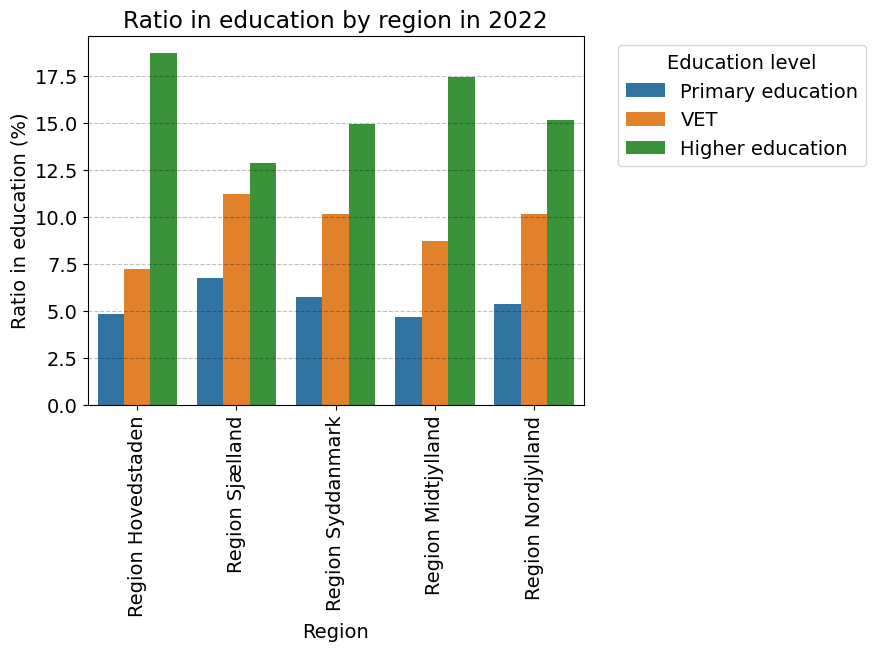

In [22]:

# Create stacked bar plot
sns.barplot(data=final_df, x='REGION', y='ratio_in_education', hue='UDDANNELSE')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Set axis labels and title
plt.xlabel('Region')
plt.ylabel('Ratio in education (%)')
plt.title('Ratio in education by region in 2022')

# Add legend
plt.legend(title='Education level', bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
# Pivot data to wide format
pivot_df = final_df.pivot(index='REGION', columns='UDDANNELSE', values='ratio_in_education')

# Create stacked bar chart
pivot_df.plot(kind='bar', stacked=True)

# Set axis labels and title
plt.xlabel('Region')
plt.ylabel('Ratio in education (%)')
plt.title('Ratio in education by region and education level')

# Move legend outside of plot
plt.legend(title='Education level', bbox_to_anchor=(1.05, 1), loc='upper left')

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.